In [ ]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.signal
import matplotlib.pylab as plt
from ipywidgets import interact, FloatSlider, IntSlider
from IPython.display import YouTubeVideo

# Ondas gravitacionales


In [ ]:
YouTubeVideo('p43sb92YOww')

Una onda gravitacional es una perturbación en el espacio-tiempo causada por la interacción de dos cuerpos super masivos

La onda gravitacional fue predicha por Einstein en base a su teoría de relatividad general.

Sin embargo no fue hasta 2016 cuando el Laser Interferometer Gravitational-Wave Observatory (LIGO) observó la primera onda gravitacional

Las ondas graviatacionales nos permiten estudiar objetos astronómicos que son dificiles o imposibles de observar por otros medios, por ejemplo los agujeros negros

Sin embargo la onda gravitacional recibida por nosotros en la Tierra es muy débil y altamente contaminada por ruido

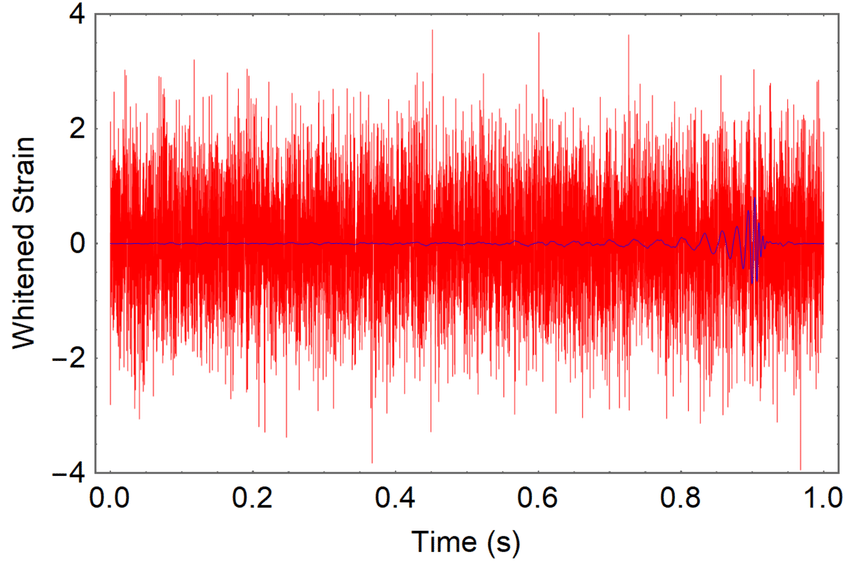

La técnica usada por la colaboración LIGO para detectarla fue el match filter

# Actividad: Match filter

EL match filter es un filtro muy sencillo pero muy robusto

Se usa para detectar una señal $x$ a partir de datos $y$ contaminados con ruido aditivo $v$

$$
y = x + v,
$$

En el siguiente ejemplo hay una señal escondida en el ruido...

In [ ]:
np.random.seed(1234)

true_length, true_freq, true_loc = 150, 0.1234, 3210

def gravitational_wave(length, freq):
    time = np.arange(0, length)
    signal = np.sin(2.0*np.pi*freq*time)*(time)/(0.8*length)
    signal[time > 0.8*length] = 0
    return signal


x = np.zeros(shape=(10000,))
x[true_loc:true_loc+true_length] = gravitational_wave(true_length, true_freq)
y =  x + 0.5*np.random.randn(*x.shape)
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(y);

Intentaremos recuperar la señal escondida usando un match filter

Para esto primero necesitamos un modelo parámetrico de $x$ 

Este modelo o *template* será nuestro filtro $h$

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)

def update(length, freq):
    ax.cla()
    ax.plot(gravitational_wave(length, freq))
    
interact(update, 
         length=IntSlider(min=10, max=1000, step=1, value=100),
         freq=FloatSlider(min=0.01, max=0.2, step=1e-2, value=0.1), 
         );

El objetivo es buscar el mejor filtro $h$ que convolucionado con $y$ nos revele $x$

El resultado del match filter es que el mejor filtro $h$ es $x^*$ (el conjugado de x)

Para encontrar los mejores "parámetros" del filtro se puede usar una estrategia de tipo fuerza bruta

Podemos incrementar progresivamente la grilla de búsqueda en torno a la mejor solución

In [ ]:
lengths = np.arange(20, 1000, step=10)
freqs = np.arange(0.01, 0.25, step=1e-2)
best_value = np.zeros(shape=(len(lengths), len(freqs)))
best_location = np.zeros_like(best_value)

for i, length in enumerate(lengths):
    for j, freq in enumerate(freqs):
        h = gravitational_wave(length, freq)
        yy = scipy.signal.correlate(y, h, mode='valid')/np.sqrt(np.sum(h**2))
        best_location[i, j] = np.argmax(yy)
        best_value[i, j] = np.max(yy)
        
fig, ax = plt.subplots(figsize=(6 ,4), tight_layout=True)
ax.pcolormesh(freqs, lengths, best_value, shading='auto', cmap=plt.cm.Blues)

idx = np.unravel_index(np.argmax(best_value), best_value.shape)
print(lengths[idx[0]], freqs[idx[1]])
print(best_location[idx[0], idx[1]])

El mejor filtro (naranjo) versus la señal real (azul)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 5), tight_layout=True)
ax[0].plot(y)

for h in [gravitational_wave(true_length, true_freq), 
          gravitational_wave(lengths[idx[0]], freqs[idx[1]])
          ]:
    
    yy = scipy.signal.correlate(y, h, mode='valid')/np.sqrt(np.sum(h**2))
    ax[1].plot(yy)
    ax[2].plot(h)

- Requiere que el ruido sea aditivo
- El template debe ser idealmente idéntico a la señal que se busca
- El método de fuerza bruta es muy costoso. Modelos más flexibles con más parámetros se vuelven rapidamente infactibles. Una alternativa es usar técnicas de optimización